In [154]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.stats import chi2_contingency

from statsmodels.stats.weightstats import DescrStatsW
from causalml.match import NearestNeighborMatch
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.genmod.families import links
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [155]:
data = pd.read_csv("/Users/yj.noh/Desktop/risk_ratio.csv", encoding = "utf-8")
print(data.isna().sum())

brms_rider_id    0
cluster          0
is_churn         0
risk_ratio       0
dtype: int64


In [156]:
print(data.shape)

(16671, 4)


In [157]:
data['risk_ratio_group'] = pd.qcut(data['risk_ratio'], 5, labels=False)
print(data['risk_ratio_group'].value_counts())

risk_ratio_group
0    3383
2    3341
3    3340
4    3320
1    3287
Name: count, dtype: int64


In [158]:
# 층화추출을 위한 조합 생성
strata = data.groupby(['risk_ratio_group', 'is_churn', 'cluster'])

# 각 조합별로 실험군과 대조군 생성
stratified_samples = []
for _, group_data in strata:
    # 그룹의 크기가 1보다 큰 경우에만 분할
    if len(group_data) > 1:
        experimental, control = train_test_split(group_data, test_size=0.5, random_state=42)
        experimental['group'] = 'experimental'
        control['group'] = 'control'
        stratified_samples.append(experimental)
        stratified_samples.append(control)
    else:
        # 그룹의 크기가 1인 경우, 해당 샘플을 한 번만 추가
        group_data['group'] = 'single_sample'
        stratified_samples.append(group_data)

# 모든 층화된 샘플을 하나의 DataFrame으로 결합
stratified_data = pd.concat(stratified_samples)

# 결과 확인
print(stratified_data[['risk_ratio','risk_ratio_group', 'is_churn', 'cluster', 'group']].head())
print(stratified_data.shape) #16671


       risk_ratio  risk_ratio_group is_churn      cluster         group
6307     1.842105                 0       이탈  new_general  experimental
16268    1.960000                 0       이탈  new_general       control
7560     1.736842                 0       이탈     part_all  experimental
12582    1.061224                 0       이탈     part_all  experimental
1154     1.200000                 0       이탈     part_all  experimental
(16671, 6)


In [159]:
stratified_data['group'].value_counts()

group
control          8345
experimental     8323
single_sample       3
Name: count, dtype: int64

In [160]:
final_df = stratified_data[stratified_data['group'].isin(['control', 'experimental'])]
print(final_df.shape)

(16668, 6)


In [161]:
print(final_df['group'].value_counts())
print(final_df['is_churn'].value_counts())

group
control         8345
experimental    8323
Name: count, dtype: int64
is_churn
잔존    8709
이탈    7959
Name: count, dtype: int64


In [162]:
print(final_df['group'].isna().sum())
print(final_df['is_churn'].isna().sum())

0
0


In [165]:
numerical_columns = ['risk_ratio']
categorical_columns = ['risk_ratio_group', 'cluster', 'is_churn']

# 수치형 변수에 대한 t-test 및 Wilcoxon rank sum test
for col in numerical_columns:
    control = final_df[final_df['group'] == 'control'][col]
    experimental = final_df[final_df['group'] == 'experimental'][col]

    ttest_pvalue = stats.ttest_ind(control, experimental, equal_var=False).pvalue
    wilcoxon_pvalue = stats.ranksums(control, experimental).pvalue

    print(f"{col} - t-test p-value: {ttest_pvalue}")
    print(f"{col} - Wilcoxon rank sum test p-value: {wilcoxon_pvalue}")

risk_ratio - t-test p-value: 0.8910343890194128
risk_ratio - Wilcoxon rank sum test p-value: 0.7392911996438314


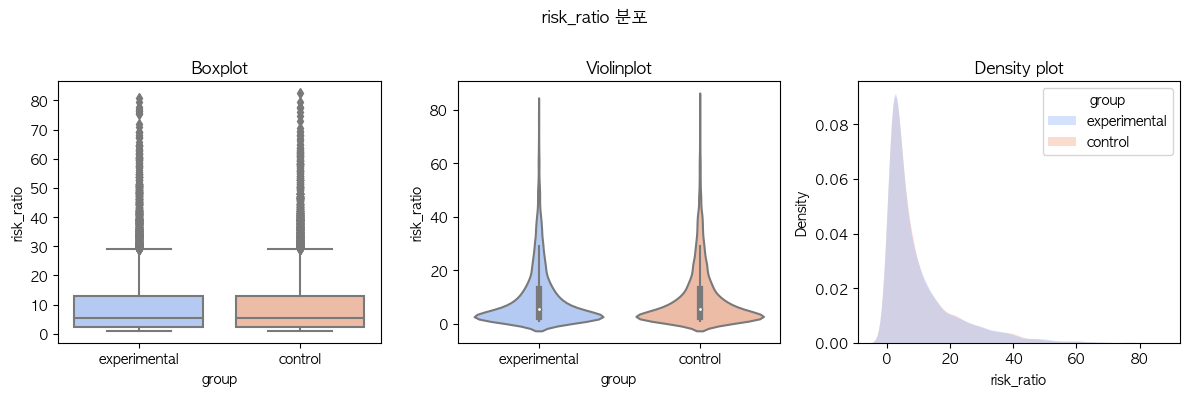

In [168]:
# palette = plasma, coolwarm, magma, BuGn, Dark2 
def plot_numeric (data, num_var, outcome):
  
    palette = 'coolwarm'
    
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    fig.suptitle(f'{num_var} 분포', fontsize = 12)

    # Boxplot
    sns.boxplot(ax=axs[0], x= outcome, y=num_var, data= data, palette = palette)
    axs[0].set_title('Boxplot')

    # Violinplot
    sns.violinplot(ax=axs[1], x = outcome, y = num_var, data = data, palette = palette)
    axs[1].set_title('Violinplot')
    
    # KDE plot
    sns.kdeplot(ax=axs[2], data = data, x = num_var, hue = outcome, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
    axs[2].set_title('Density plot')
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.8) # title 공간 확보
    
    #fig.savefig(f'graphs_all/{num_var}_distributions.png')
    plt.show()
    plt.close(fig)

plot_numeric(final_df, 'risk_ratio', 'group')

In [ ]:
# # 범주형 변수에 대한 카이제곱검정
# for col in categorical_columns:
#     contingency_table = pd.crosstab(final_df[col], final_df['group'])
#     chi2_stat, chi2_pvalue, _, _ = chi2_contingency(contingency_table)
#     print(f"{col} - Chi-square test p-value: {chi2_pvalue}")
    

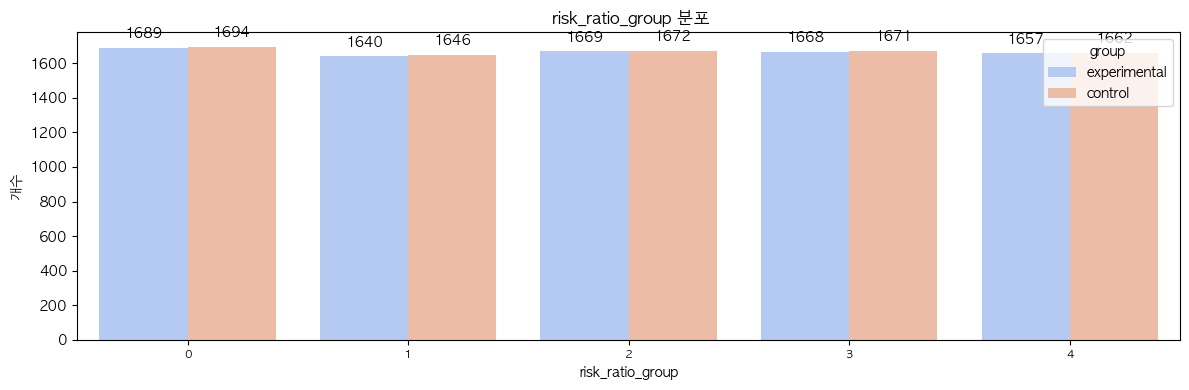

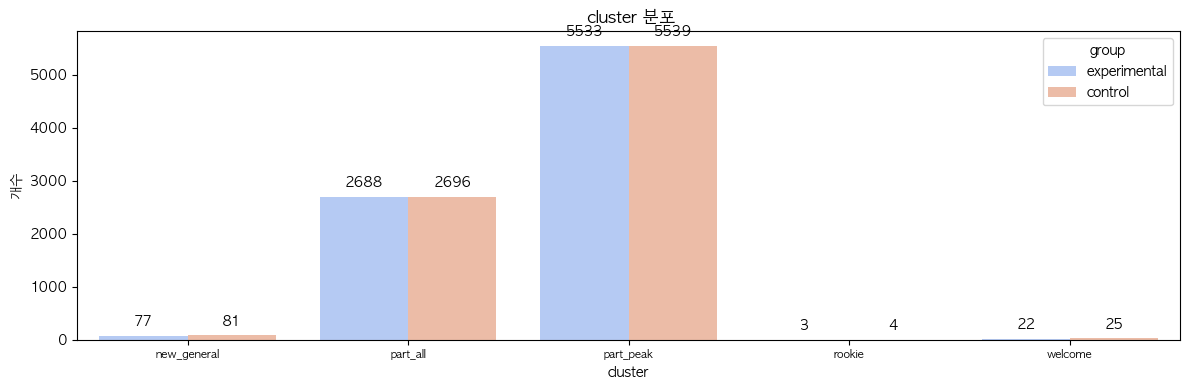

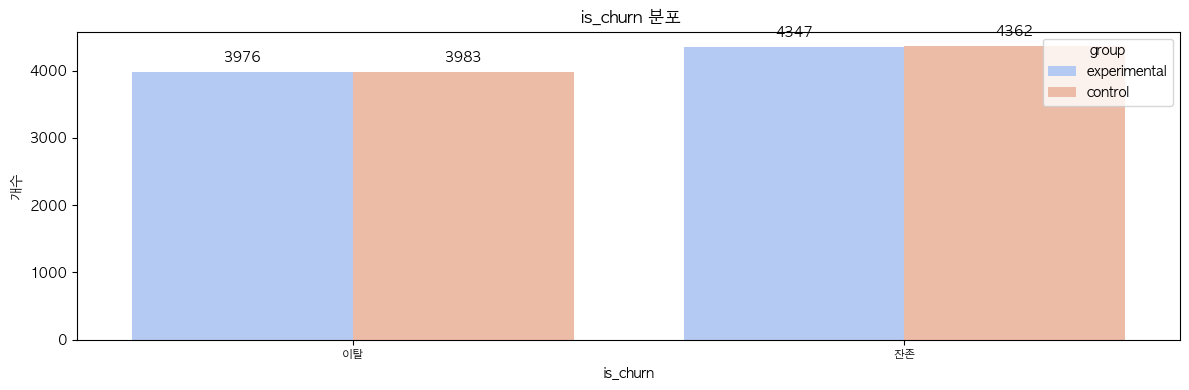

In [169]:
def plot_category(data, category_vars, outcome) : 
       
    palette = 'coolwarm'
       
    for cat_var in category_vars : 
        plt.figure(figsize = (12,4))
        ax = sns.countplot(x=cat_var, hue=outcome, data=data, palette=palette)
        plt.title(f' {cat_var} 분포')
        plt.ylabel('개수')
        plt.legend(title=outcome, loc='upper right')
        plt.xticks(fontsize=8)  # x축 글씨 조정
        
        # 각 막대에 데이터 레이블 추가
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',  # 높이 값(즉, 개수)을 얻어 텍스트로 설정
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # 텍스트 위치 설정
                        ha='center',  # 가로 정렬(center)
                        va='center',  # 세로 정렬(center)
                        xytext=(0, 10),  # 텍스트 오프셋(위쪽으로 약간 이동)
                        textcoords='offset points',  # 어떤 종류의 오프셋을 사용할지 정의
                        fontsize=10)  # 글꼴 크기    
        plt.tight_layout()
        plt.show()
        
plot_category(final_df,categorical_columns, 'group' )

In [ ]:
# np.random.seed(123)
# data['outcome'] = np.random.choice([0, 1], size=len(data), p=[0.5, 0.5])
# print(data['outcome'].value_counts())